# Burn Care Dataset: EDA and Classification Modeling

This notebook performs: LaPorchia Davis -Dataset
1. Data loading and cleaning
2. Exploratory Data Analysis (EDA)
3. Classification modeling for bone-related outcomes

**Dataset**: `burncare_cleaned_dataset.csv` (1538 rows, 37 features)

**Targets**: `has_fracture`, `has_osteomyelitis`

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc
import warnings
warnings.filterwarnings('ignore')

print('Libraries imported successfully')

Libraries imported successfully


In [2]:
# Load the cleaned dataset
df = pd.read_csv('burncare_cleaned_dataset.csv')
print('Dataset shape:', df.shape)
print('\nFirst 5 rows:')
print(df.head())

Dataset shape: (1538, 37)

First 5 rows:
  patient_id  age  gender   burn_depth injury_cause initial_surgery  \
0      P1003   36    Male  Superficial     Chemical      2024-08-19   
1      P1326   31    Male  Superficial   Electrical      2024-10-04   
2      P1290   41  Female  Superficial         Fire      2025-02-19   
3      P1462   42    Male  Superficial        Scald      2024-08-16   
4      P1080   38    Male  Superficial         Fire      2024-11-12   

  material_used material_type material_breathability  material_elasticity  \
0  SmartFabricX        Hybrid                 Medium                    1   
1        Cotton       Natural                    Low                    0   
2        Cotton       Natural                 Medium                    0   
3  SmartFabricX        Hybrid                    Low                    0   
4  SmartFabricX        Hybrid                   High                    0   

   ... second_surgery_binary  burn_severity_index  comorbidity_score 

## 1. Exploratory Data Analysis (EDA)

In [3]:
# Check for missing values
print('Total missing values:', df.isnull().sum().sum())
print('\nDataset info:')
print(df.info())

Total missing values: 0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   patient_id                   1538 non-null   object
 1   age                          1538 non-null   int64 
 2   gender                       1538 non-null   object
 3   burn_depth                   1538 non-null   object
 4   injury_cause                 1538 non-null   object
 5   initial_surgery              1538 non-null   object
 6   material_used                1538 non-null   object
 7   material_type                1538 non-null   object
 8   material_breathability       1538 non-null   object
 9   material_elasticity          1538 non-null   int64 
 10  antimicrobial_coated         1538 non-null   object
 11  second_surgery               1538 non-null   int64 
 12  time_to_second_surgery_days  1538 non-null   int64 

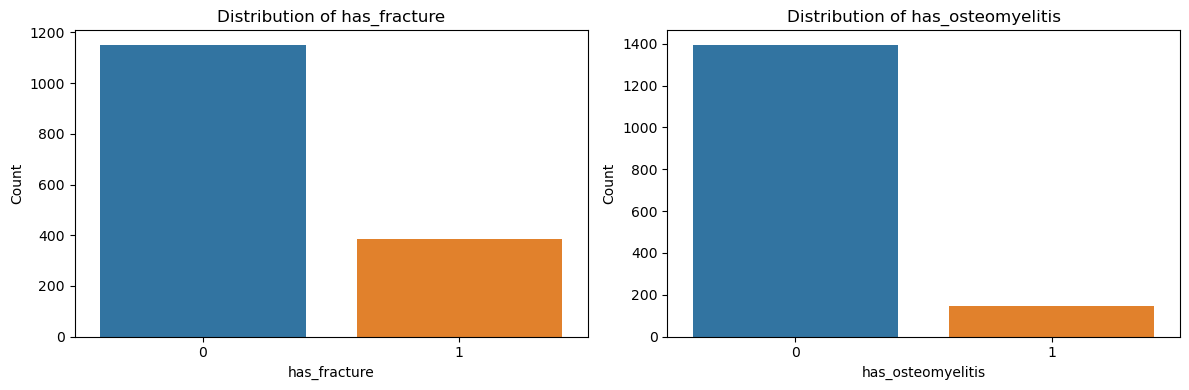


Class balance:
has_fracture: {0: 1151, 1: 387}
has_osteomyelitis: {0: 1394, 1: 144}


In [4]:
# Target variable distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x='has_fracture', data=df, ax=axes[0])
axes[0].set_title('Distribution of has_fracture')
axes[0].set_ylabel('Count')

sns.countplot(x='has_osteomyelitis', data=df, ax=axes[1])
axes[1].set_title('Distribution of has_osteomyelitis')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print('\nClass balance:')
print('has_fracture:', df['has_fracture'].value_counts().to_dict())
print('has_osteomyelitis:', df['has_osteomyelitis'].value_counts().to_dict())

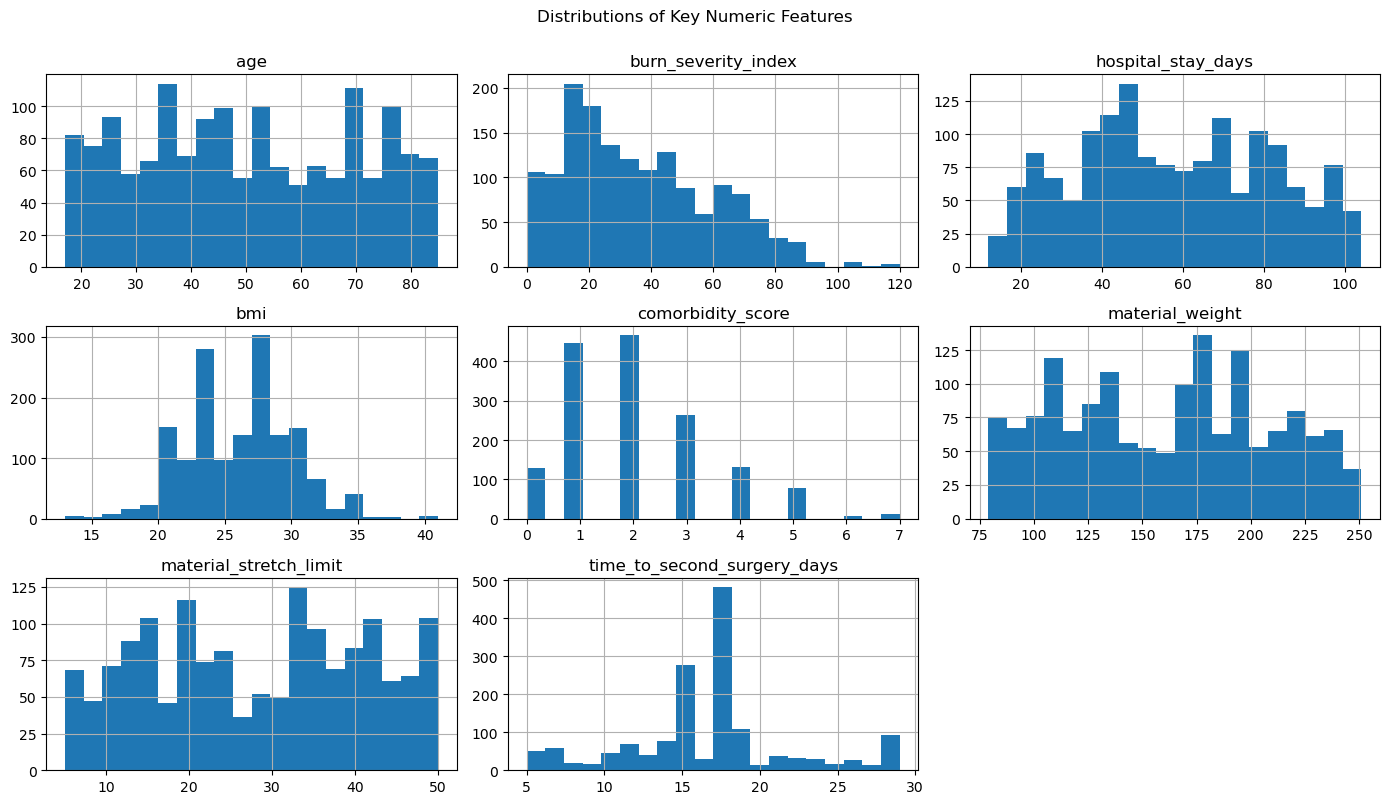

In [5]:
# Numeric feature distributions
numeric_features = ['age', 'burn_severity_index', 'hospital_stay_days', 'bmi', 'comorbidity_score', 
                   'material_weight', 'material_stretch_limit', 'time_to_second_surgery_days']

df[numeric_features].hist(bins=20, figsize=(14, 8), layout=(3, 3))
plt.suptitle('Distributions of Key Numeric Features', y=1.00)
plt.tight_layout()
plt.show()

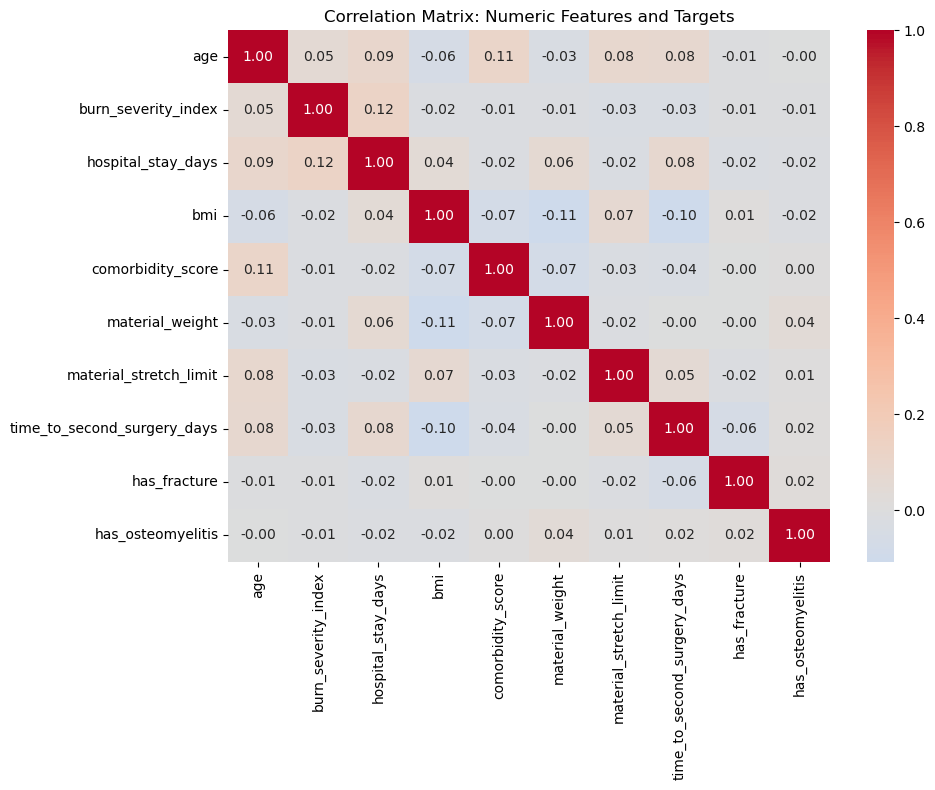

In [6]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_features + ['has_fracture', 'has_osteomyelitis']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Numeric Features and Targets')
plt.tight_layout()
plt.show()

## 2. Classification Modeling

In [7]:
# Prepare features and targets
id_cols = ['patient_id', 'initial_surgery']
target_cols = ['has_fracture', 'has_osteomyelitis', 'bone_damage_score', 'bone_density_loss', 
               'bone_erosion_extent', 'calcium_deposition', 'fracture_count']

feature_cols = [c for c in df.columns if c not in id_cols + target_cols]

numeric_cols = [c for c in feature_cols if df[c].dtype != 'object']
categorical_cols = [c for c in feature_cols if df[c].dtype == 'object']

print('Total features:', len(feature_cols))
print('Numeric features:', len(numeric_cols))
print('Categorical features:', len(categorical_cols))

Total features: 28
Numeric features: 19
Categorical features: 9


In [8]:
# Create preprocessing pipeline
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

print('Preprocessing pipeline created')

Preprocessing pipeline created


In [9]:
# Train/test split
X = df[feature_cols]
y_fracture = df['has_fracture']
y_osteomyelitis = df['has_osteomyelitis']

X_train, X_test, y_frac_train, y_frac_test, y_osteo_train, y_osteo_test = train_test_split(
    X, y_fracture, y_osteomyelitis, test_size=0.2, random_state=42, stratify=y_fracture
)

print('Training set size:', X_train.shape[0])
print('Test set size:', X_test.shape[0])

Training set size: 1230
Test set size: 308


In [10]:
# Build and train classifier for has_fracture
model_fracture = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced', n_jobs=-1))
])

model_fracture.fit(X_train, y_frac_train)
print('Model trained for has_fracture')

Model trained for has_fracture


=== has_fracture Model Performance ===
Test Accuracy: 0.597
Test ROC-AUC: 0.52
Test PR-AUC: 0.297

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       230
           1       0.27      0.33      0.30        78

    accuracy                           0.60       308
   macro avg       0.51      0.51      0.51       308
weighted avg       0.63      0.60      0.61       308



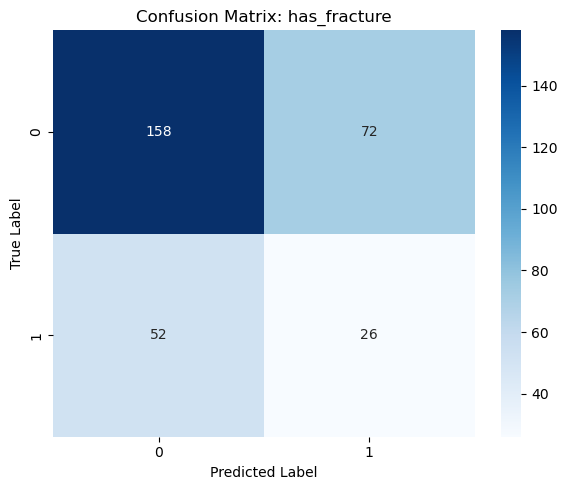

In [11]:
# Evaluate has_fracture model
y_pred = model_fracture.predict(X_test)
y_pred_proba = model_fracture.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_frac_test, y_pred)
roc_auc = roc_auc_score(y_frac_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_frac_test, y_pred_proba)
pr_auc = auc(recall, precision)

print('=== has_fracture Model Performance ===')
print('Test Accuracy:', round(acc, 3))
print('Test ROC-AUC:', round(roc_auc, 3))
print('Test PR-AUC:', round(pr_auc, 3))
print('\nClassification Report:')
print(classification_report(y_frac_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_frac_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: has_fracture')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [12]:
# Build and train classifier for has_osteomyelitis
model_osteomyelitis = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced', n_jobs=-1))
])

model_osteomyelitis.fit(X_train, y_osteo_train)
print('Model trained for has_osteomyelitis')

Model trained for has_osteomyelitis


=== has_osteomyelitis Model Performance ===
Test Accuracy: 0.815
Test ROC-AUC: 0.491
Test PR-AUC: 0.09

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       280
           1       0.09      0.11      0.10        28

    accuracy                           0.81       308
   macro avg       0.50      0.50      0.50       308
weighted avg       0.83      0.81      0.82       308



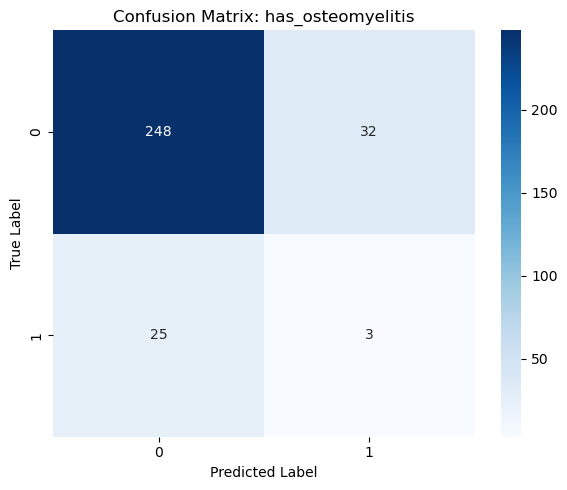

In [13]:
# Evaluate has_osteomyelitis model
y_pred = model_osteomyelitis.predict(X_test)
y_pred_proba = model_osteomyelitis.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_osteo_test, y_pred)
roc_auc = roc_auc_score(y_osteo_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_osteo_test, y_pred_proba)
pr_auc = auc(recall, precision)

print('=== has_osteomyelitis Model Performance ===')
print('Test Accuracy:', round(acc, 3))
print('Test ROC-AUC:', round(roc_auc, 3))
print('Test PR-AUC:', round(pr_auc, 3))
print('\nClassification Report:')
print(classification_report(y_osteo_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_osteo_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: has_osteomyelitis')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [16]:
#imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

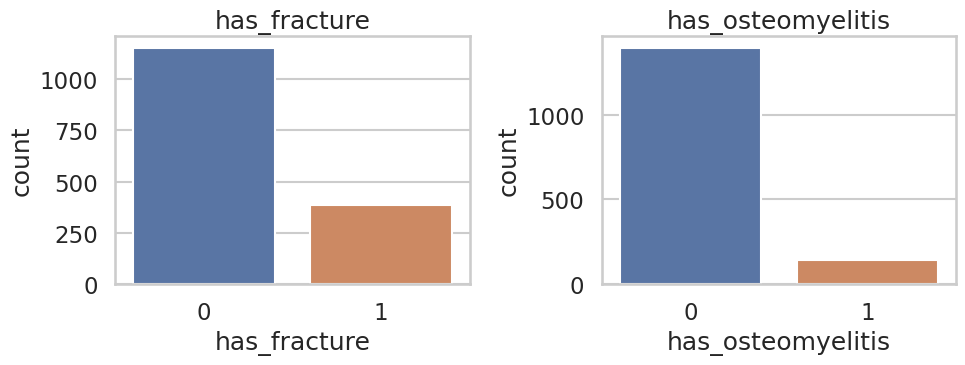

In [17]:
# Class balance plots
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.countplot(x='has_fracture', data=df)
plt.title('has_fracture')

plt.subplot(1, 2, 2)
sns.countplot(x='has_osteomyelitis', data=df)
plt.title('has_osteomyelitis')

plt.tight_layout()
plt.show()

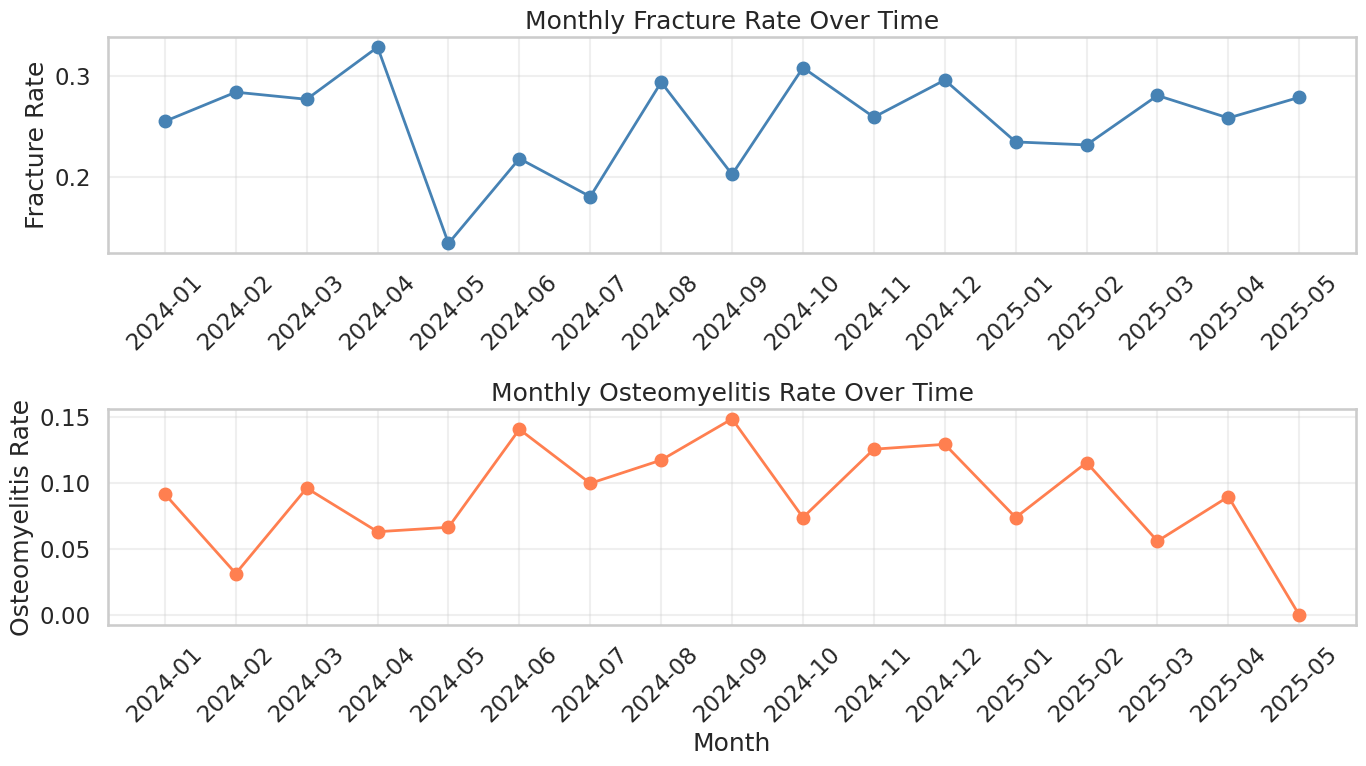

In [19]:
# Time-aware trends: monthly rates of outcomes
df['initial_surgery_date'] = pd.to_datetime(df['initial_surgery'], errors='coerce')
df['year_month'] = df['initial_surgery_date'].dt.to_period('M')

monthly_trends = df.groupby('year_month').agg({
    'has_fracture': 'mean',
    'has_osteomyelitis': 'mean',
    'patient_id': 'count'
}).reset_index()

monthly_trends.columns = ['year_month', 'fracture_rate', 'osteomyelitis_rate', 'patient_count']
monthly_trends['year_month_str'] = monthly_trends['year_month'].astype(str)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(monthly_trends['year_month_str'], monthly_trends['fracture_rate'],
             marker='o', color='steelblue', linewidth=2)
axes[0].set_title('Monthly Fracture Rate Over Time')
axes[0].set_ylabel('Fracture Rate')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3)

axes[1].plot(monthly_trends['year_month_str'], monthly_trends['osteomyelitis_rate'],
             marker='o', color='coral', linewidth=2)
axes[1].set_title('Monthly Osteomyelitis Rate Over Time')
axes[1].set_ylabel('Osteomyelitis Rate')
axes[1].set_xlabel('Month')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

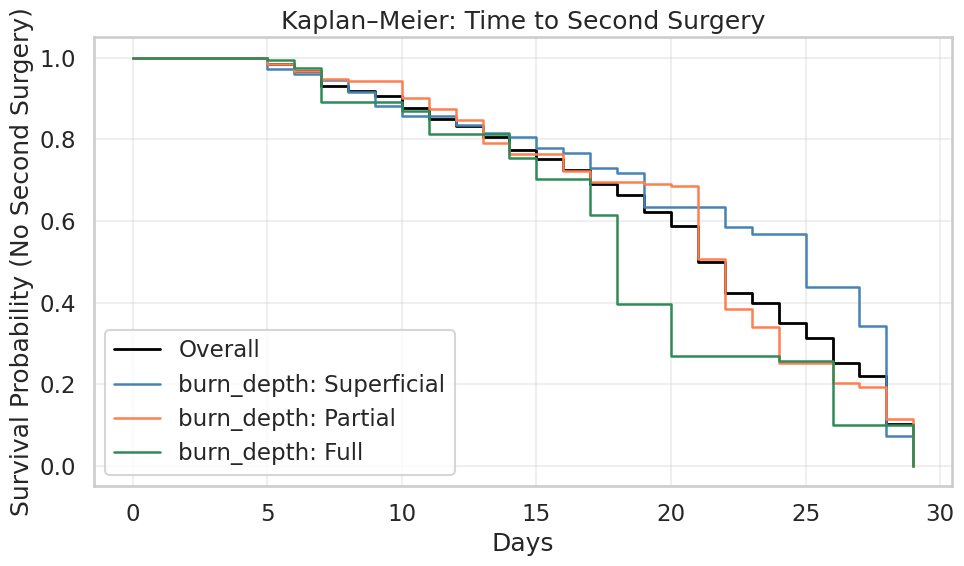

In [22]:
# Kaplan–Meier survival curves (manual implementation, no lifelines dependency)
import numpy as np
import matplotlib.pyplot as plt

# Prepare duration and event
dur = df['time_to_second_surgery_days']
if 'second_surgery_binary' in df.columns:
    event = df['second_surgery_binary']
else:
    # If second_surgery is Yes/No or 1/0 string/numeric, coerce to int 0/1
    event = pd.to_numeric(df['second_surgery'], errors='coerce')

km_df = pd.DataFrame({'duration': dur, 'event': event}).dropna()
km_df = km_df[km_df['duration'] >= 0]

def km_curve(durations, events):
    order = np.argsort(durations.values)
    t = durations.values[order]
    e = events.values[order]
    unique_times = np.unique(t)
    n_at_risk = len(t)
    surv_times = [0]
    surv_probs = [1.0]
    for ut in unique_times:
        d_i = np.sum((t == ut) & (e == 1))
        c_i = np.sum((t == ut) & (e == 0))
        if n_at_risk > 0 and d_i > 0:
            surv_probs.append(surv_probs[-1] * (1.0 - d_i / n_at_risk))
            surv_times.append(ut)
        n_at_risk = n_at_risk - d_i - c_i
    return np.array(surv_times), np.array(surv_probs)

# Overall KM
t_overall, s_overall = km_curve(km_df['duration'], km_df['event'])

plt.figure(figsize=(10, 6))
plt.step(t_overall, s_overall, where='post', label='Overall', linewidth=2, color='black')

# Stratify by burn_depth if available
if 'burn_depth' in df.columns:
    colors = ['steelblue', 'coral', 'seagreen', 'purple', 'gray']
    for i, val in enumerate(df['burn_depth'].dropna().unique().tolist()[:4]):
        sub = df[df['burn_depth'] == val]
        sub_km = pd.DataFrame({
            'duration': sub['time_to_second_surgery_days'],
            'event': sub['second_surgery_binary'] if 'second_surgery_binary' in df.columns else pd.to_numeric(sub['second_surgery'], errors='coerce')
        }).dropna()
        sub_km = sub_km[sub_km['duration'] >= 0]
        if len(sub_km) < 5:
            continue
        t_s, s_s = km_curve(sub_km['duration'], sub_km['event'])
        plt.step(t_s, s_s, where='post', label=f'burn_depth: {val}', color=colors[i % len(colors)], linewidth=1.8)

plt.title('Kaplan–Meier: Time to Second Surgery')
plt.xlabel('Days')
plt.ylabel('Survival Probability (No Second Surgery)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

ROC-AUC: 1.0


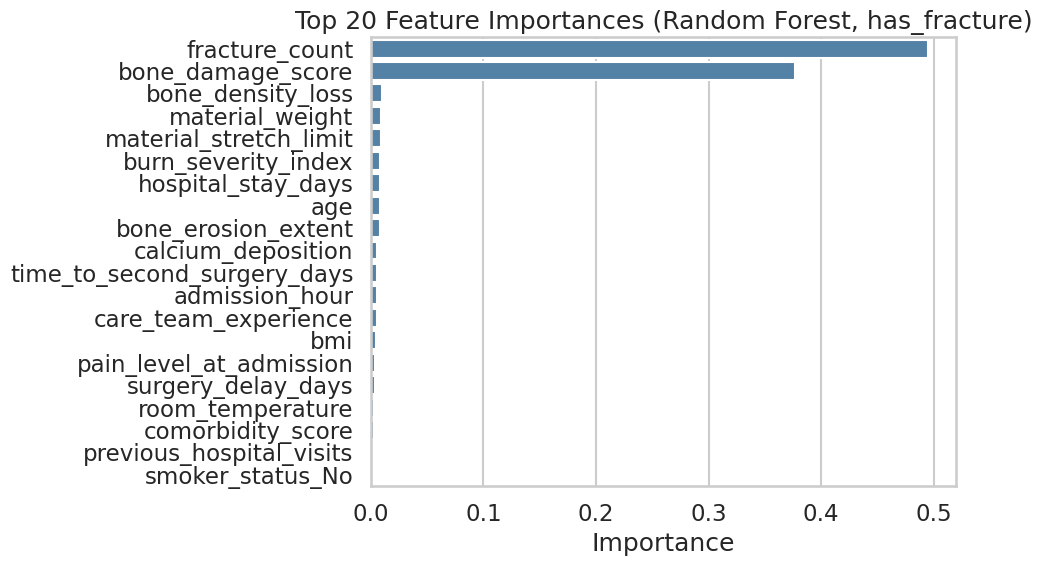

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

target = 'has_fracture'
y = df[target]

# Exclude obvious IDs/dates and targets
drop_cols = ['patient_id', 'initial_surgery', 'initial_surgery_date', 'year_month', 'year', 'month',
             'has_fracture', 'has_osteomyelitis']
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ]
)

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)

pipe = Pipeline(steps=[('prep', preprocess), ('model', rf)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)
pred_proba = pipe.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, pred_proba)
print('ROC-AUC:', round(auc, 4))

# Get feature importances back to original names
onehot = pipe.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = onehot.get_feature_names_out(cat_cols).tolist() if len(cat_cols) > 0 else []
feature_names = num_cols + cat_feature_names

importances = pipe.named_steps['model'].feature_importances_
imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=imp.values, y=imp.index, color='steelblue')
plt.title('Top 20 Feature Importances (Random Forest, has_fracture)')
plt.xlabel('Importance')
plt.ylabel('')
plt.tight_layout()
plt.show()